# Cloud and Quality Masking

* **Products used:** 
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr) 


## Background
In the past, remote sensing researchers would reject partly cloud-affected scenes in favour of cloud-free scenes. 
However, multi-temporal analysis techniques increasingly make use of every quality assured pixel within a time series of observations. 
The capacity to automatically exclude low quality pixels (e.g. clouds, shadows or other invalid data) is essential for enabling these new remote sensing methods.

Analysis-ready satellite data from Digital Earth Africa includes pixel quality information that can be used to easily "mask" data (i.e. keep only certain pixels in an image) to obtain a time series containing only clear or cloud-free pixels.

## Description
In this notebook, we show how to mask Digital Earth Africa satellite data using boolean masks. The notebook demonstrates how to:

1. Load in a time series of satellite data including the `pixel_qa` pixel quality band
2. Inspect the band's `flags_definition` attributes
3. Create a mask where pixels are cloudy, have cloud-shadow, or no-data
4. Apply binary morphological operators on the cloudy pixels to improve the mask
5. Apply the masks to the staellite data so we retain only the good quality observations, and plot the results
6. Use `load_ard` to mask poor quality pixels, while taking advantage of the morphological operators parameter

Digital Earth Africa provides wrapper functions that will automatically provide cloud-masked satellite data, more information can be found in the [Using_load_ard](./Using_load_ard.ipynb) notebook.

***

## Getting started
First we import relevant packages and connect to the datacube. 
Then we define our example area of interest and load in a time series of satellite data.

In [1]:
# !/env/bin/python3 -m pip install --upgrade pip
# !pip install pystac==1.0.0rc2 --upgrade
# !pip install odc-algo --extra-index-url="https://packages.dea.ga.gov.au" --upgrade

In [2]:
# !pip uninstall deafrica-tools -y
# !pip install ../Tools/

In [3]:
%matplotlib inline

import xarray
import numpy
import datacube
import scipy.ndimage
from pprint import pprint
from odc.algo import mask_cleanup

from datacube.utils import masking
from odc.algo import keep_good_only, erase_bad

from deafrica_tools.plotting import rgb
from deafrica_tools.datahandling import mostcommon_crs, load_ard

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

In [4]:
dc = datacube.Datacube(app="Masking_data")

## Create a query and load satellite data

To demonstrate how to mask satellite data, we will load Landsat 8 surface reflectance RGB data along with a pixel quality classification band called `pixel_quality`.

In [5]:
# Region of interest
lat, lon = 35.7718, -5.8096
buffer = 0.03

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2016-09', '2016-10-04'),
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_sr', query=query)

# Load data from the Landsat-8
data = dc.load(product="ls8_sr",
               measurements=["blue", "green", "red", "pixel_quality"],
               output_crs=output_crs,
               resolution=(-30, 30),
               align=(15, 15),
               **query)
print(data)

/env/lib/python3.6/site-packages/deafrica_tools/datahandling.py:735: UserWarning: Multiple UTM zones ['epsg:32630', 'epsg:32629'] were returned for this query. Defaulting to the most common zone: epsg:32630
  UserWarning,


<xarray.Dataset>
Dimensions:        (time: 4, x: 188, y: 228)
Coordinates:
  * time           (time) datetime64[ns] 2016-09-02T11:03:08.816501 ... 2016-...
  * y              (y) float64 3.966e+06 3.966e+06 ... 3.959e+06 3.959e+06
  * x              (x) float64 2.432e+05 2.432e+05 ... 2.488e+05 2.488e+05
    spatial_ref    int32 32630
Data variables:
    blue           (time, y, x) uint16 8398 8338 8295 8216 ... 17132 19545 18233
    green          (time, y, x) uint16 8813 8771 8707 8622 ... 21291 22032 22456
    red            (time, y, x) uint16 8235 8199 8136 8077 ... 22480 23551 23042
    pixel_quality  (time, y, x) uint16 23888 23888 23888 ... 21824 21824 21824
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref


The absence of satellite observation is indicated by a "nodata" value for the band, which is listed under the **Attributes** category of the returned `xarray.DataArray`.

In [6]:
print(data.red.attrs)

{'units': '1', 'nodata': 0, 'crs': 'epsg:32630', 'grid_mapping': 'spatial_ref'}


We see that the `nodata` attribute reports the value `0`.

We can find the classification scheme of the `pixel_qa` band in its flags definition.

In [7]:
flags_def = data.pixel_quality.attrs["flags_definition"]
pprint(flags_def)

{'cirrus': {'bits': 2,
            'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
 'cirrus_confidence': {'bits': [14, 15],
                       'values': {'0': 'none',
                                  '1': 'low',
                                  '2': 'reserved',
                                  '3': 'high'}},
 'clear': {'bits': 6, 'values': {'0': False, '1': True}},
 'cloud': {'bits': 3,
           'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
 'cloud_confidence': {'bits': [8, 9],
                      'values': {'0': 'none',
                                 '1': 'low',
                                 '2': 'medium',
                                 '3': 'high'}},
 'cloud_shadow': {'bits': 4,
                  'values': {'0': 'not_high_confidence',
                             '1': 'high_confidence'}},
 'cloud_shadow_confidence': {'bits': [10, 11],
                             'values': {'0': 'none',
                                        '1':

We see that `pixel_quality` also reports the `nodata` pixels, and along with the `cloud` and `cloud_shadow` pixels, it also picks up `snow` and `water` pixels.

## Creating a cloud and pixel quality mask

We create a mask by specifying conditions that our pixels must satisfy.
But we will only need the labels (not the values) to create a mask.

In [8]:
quality_flags = dict(
                cloud="high_confidence", # True where there is cloud
                cirrus="high_confidence",# True where there is cirrus cloud
                cloud_shadow="high_confidence",# True where there is cloud shadow
                nodata=True 
)

# set cloud_mask: True=cloud, False=non-cloud
mask, _= masking.create_mask_value(flags_def, **quality_flags)
data['cloud_mask'] = (data['pixel_quality'] & mask) != 0

Below, we'll plot the mask along with the true colour satellite images.

Does the cloud mask exactly match the clouds you see in the RGB plots? Landsat's pixel quality algorithm has known limitations that result in bright objects, such as beaches and cities, mistakenly being classified as clouds.

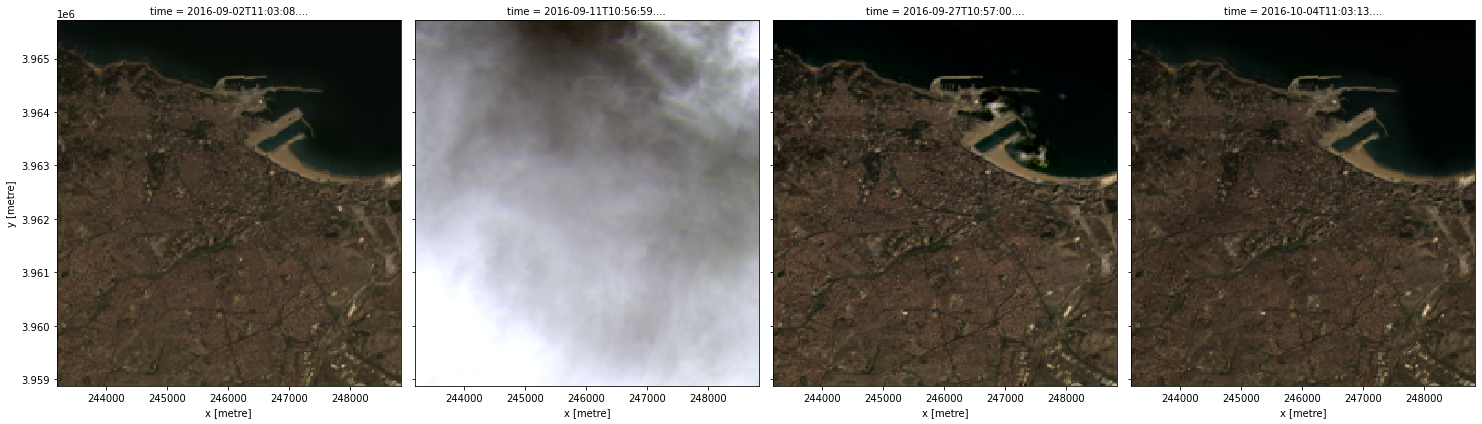

In [9]:
# Plot the data
rgb(data, col="time", col_wrap=8)

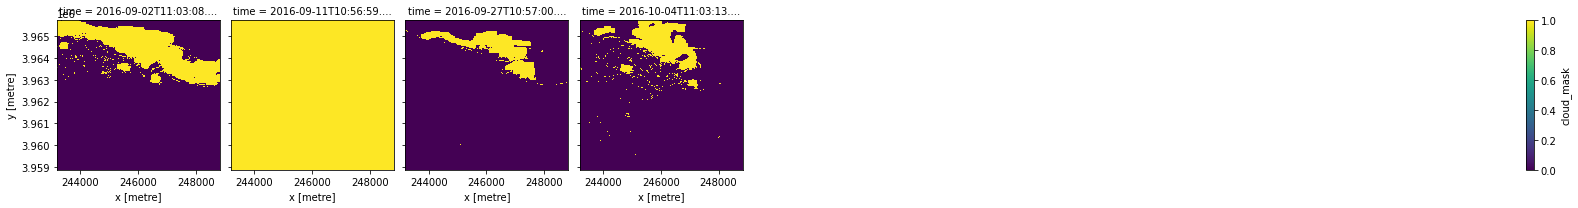

In [10]:
#plot the locations where there are clouds and cloud shadows
data['cloud_mask'].plot(col="time", col_wrap=8);

## Cloud mask morphological operators

We can improve on the false positives detected by Landsat's pixel quality mask by applying binary moprhological image processing techniques (e.g. [binary_closing](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.morphology.binary_closing.html#scipy.ndimage.morphology.binary_closing), [binary_erosion](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.morphology.binary_erosion.html#scipy.ndimage.morphology.binary_erosion) etc.). The Open-Data-Cube library [odc-algo](https://github.com/opendatacube/odc-tools/tree/develop/libs/algo) has a function, `odc.algo.mask_cleanup` that can perform a few of these operations.  Below, we will try to imporve the cloud mask by apply a number of the filters.

Feel free to experiment with the values in `filters`


In [11]:
# set the filters to apply. The integers refer to the number of pixels
filters = [('erosion', 5),("closing", 2),("opening", 2),("dilation", 1)]

In [12]:
# Use the mask_cleanup function to apply the filters
data['cloud_mask_filtered'] = mask_cleanup(data['cloud_mask'], mask_filters=filters)

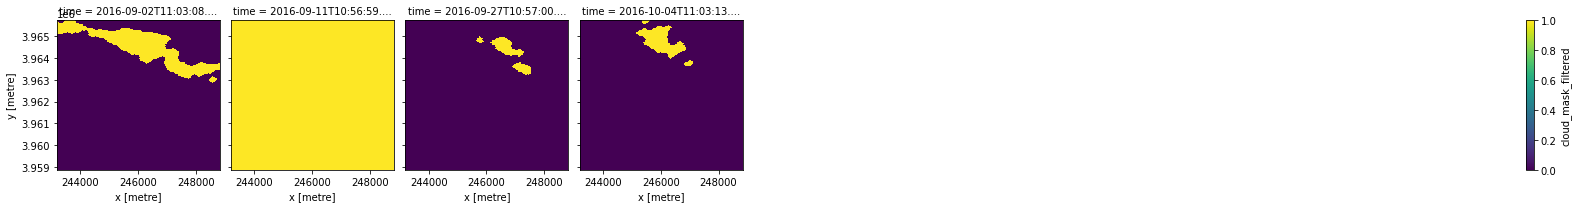

In [13]:
#plot the results
data['cloud_mask_filtered'].plot(col="time", col_wrap=8);

### Applying the cloud-mask

We can now get the clear images we want by erasing the cloud and non-data pixels from the data

In [14]:
# erase pixels with cloud
clear = erase_bad(data.drop_vars(['cloud_mask_filtered', 'cloud_mask']),
                                      data['cloud_mask'])

#erase pixels with the cloud_filtering
clear_filtered = erase_bad(data.drop_vars(['cloud_mask_filtered', 'cloud_mask']),
                                      data['cloud_mask_filtered'])


### Plot the results of our 'clear' masking 

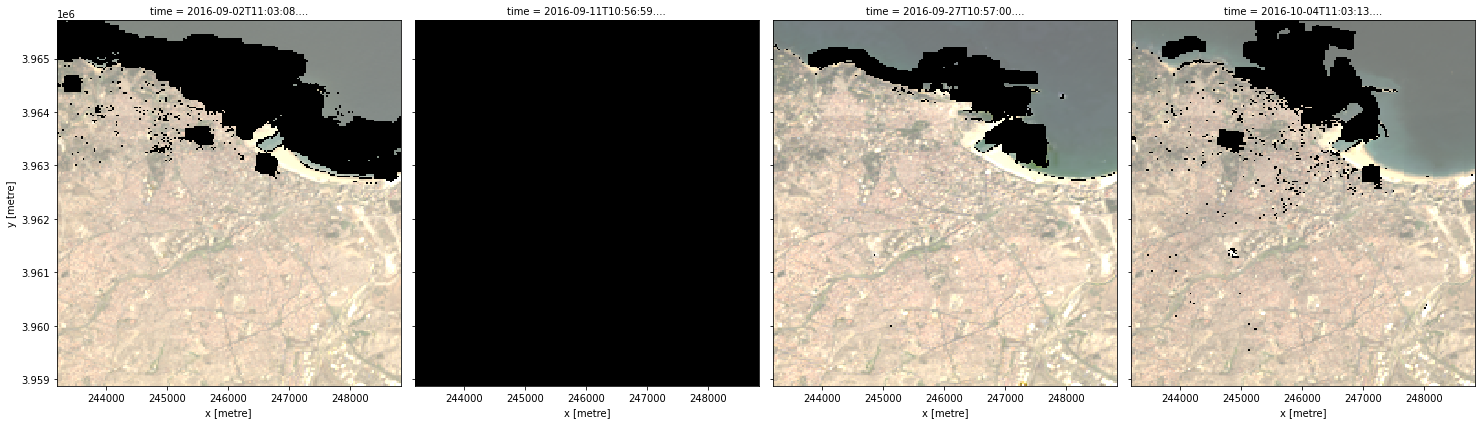

In [15]:
rgb(clear, col="time", col_wrap=8)

### Plot the results of our 'clear_filtered' masking 

As you can see, the morphological filtering operations have minimised the impact of the false-postives in the cloud mask over the cities and along the coast

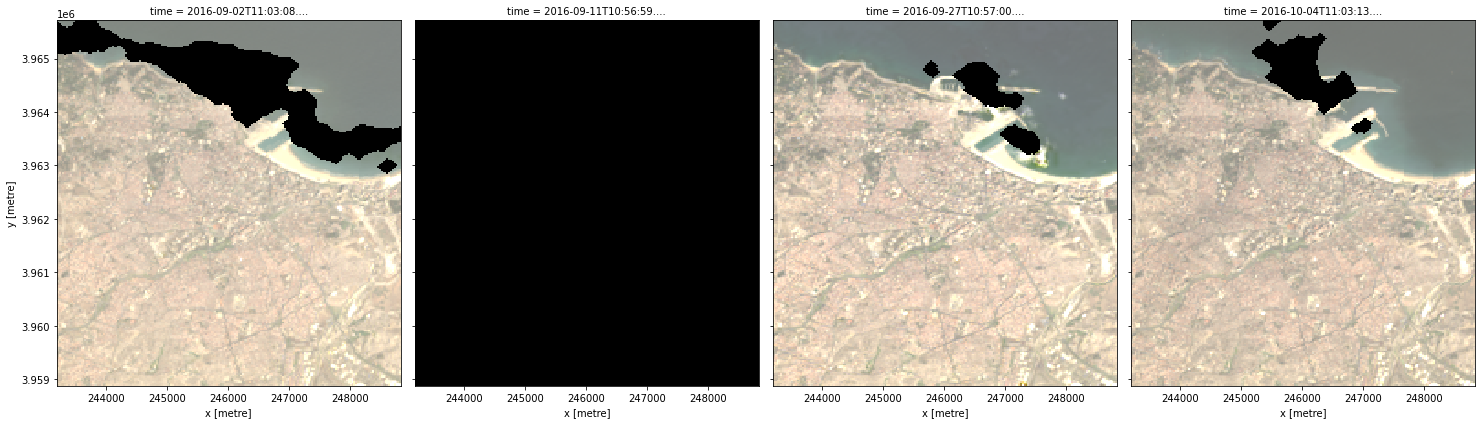

In [16]:
rgb(clear_filtered, col="time", col_wrap=8)

## Morphological filtering with `load_ard`

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Applying morphological filters to pq mask [('erosion', 20), ('closing', 2), ('opening', 2), ('dilation', 1)]
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 4 time steps


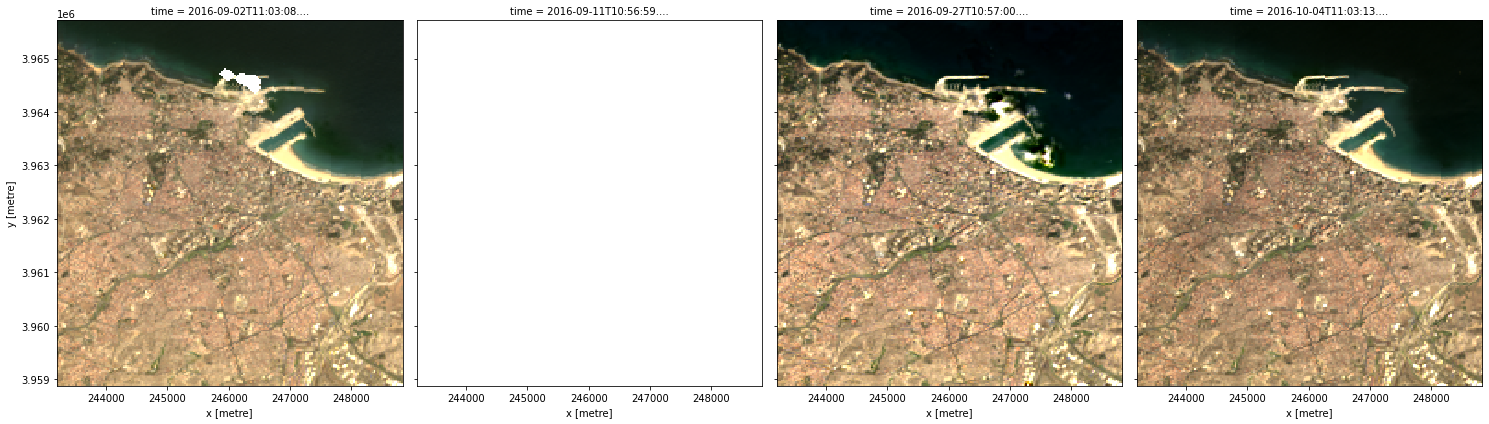

In [22]:
# set the filters to apply
filters = [('erosion', 10),("closing", 2),("opening", 2),("dilation", 1)]

# # Load data from the Landsat-8
data = load_ard(dc=dc,
               products=["ls8_sr"],
               measurements=["blue", "green", "red"],
               mask_filters=filters,
               output_crs=output_crs,
               resolution=(-30, 30),
               align=(15,15),
               **query)

rgb(data, col="time", col_wrap=4)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')